In [77]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import matplotlib
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from spacy.lang.en.examples import sentences 
import spacy as sp
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
#nltk.download('stopwords')
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing import text
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

# import zipfile
from textblob import TextBlob
import string
import re

In [149]:
tweets = pd.read_csv('data/TrumpTweetsCleaned.csv')
#09-11-2017 to 02-16-2018
before = pd.to_datetime('2017-09-11')
after = pd.to_datetime('2018-02-16')
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

# Preprocessing (James)

In [150]:
#preprocessing functions for the dataframe
def delete_punct(text):
    '''
    removes special characters from the document
    '''
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct 
def remove_stopwords(text):
    '''
    removes all stopwords according to the pre-built english dictionary of known stopwords
    '''
    words = [w for w in text if w not in set(stopwords.words('english'))]
    return words
def lemmatize(text):
    '''
    returns the lemmas of each word in the document
    '''
    lemmatized = [lemmatizer.lemmatize(i) for i in text]
    return lemmatized
def joiner(text):
    '''
    joins the comma-separated list into one string
    '''
    joined = " ".join([i for i in text])
    return joined
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

In [151]:
def preproc_pipeline(tweets):
    '''
    The preprocessing pipline applied to each document in the dataframe
    '''
    tweets['preproc'] = tweets['text'].apply(lambda x: delete_punct(x))
    tweets['preproc'] = tweets['preproc'].apply(lambda x: tokenizer.tokenize(x.lower()))
    tweets['preproc'] = tweets['preproc'].apply(lambda x: remove_stopwords(x))
    tweets['preproc'] = tweets['preproc'].apply(lambda x: lemmatize(x))
    tweets['preproc'] = tweets['preproc'].apply(lambda x: joiner(x))
    return tweets

In [152]:
tweets = preproc_pipeline(tweets)

In [167]:
# fitting sk-learn's TF-IDF Vectorizer to our dataframe and returning list of most important keywords
docs = tweets['preproc'].tolist()
tfidf = TfidfVectorizer(max_features = 2500, min_df = 10, max_df = .9)
tfidf2 = TfidfVectorizer(max_features = 150, min_df = 160, max_df = .9)
X = tfidf.fit_transform(docs).toarray()
feature_names = tfidf.get_feature_names()
X2 = tfidf2.fit_transform(docs).toarray()
features_names2 = tfidf2.get_feature_names()

In [168]:
def intersection(l1,l2):
    '''
    finding intersection of elements between two lists
    '''
    return list(set(l1) & set(l2))
def term_extract(df):
    '''
    Will return a column of important keywords in each document determined by TF-IDF 
    Sentiment Analysis via Textblob will only be run on these keywords 
    '''
    df['keywords'] = df['preproc'].apply(lambda x: intersection(x.split(' '), feature_names))
    df['keywords'] = df['keywords'].apply(lambda x: joiner(x))
    return df
tweets = term_extract(tweets)

In [169]:
tweets['polarity'] = [TextBlob(tweets['keywords'].values[i]).polarity for i in range(len(tweets))]
tweets['subjectivity'] = [TextBlob(tweets['keywords'].values[i]).subjectivity for i in range(len(tweets))]

In [170]:
# Delete columns 
tweets  = tweets.drop(columns = ['text', 'preproc'])

## Stock Data 

In [102]:
stock = pd.read_csv('data/SP500_intraday.csv')


In [103]:
stock['Time_pd'] = pd.to_timedelta(stock['Time']+':00')
stock['Date_time'] = pd.to_datetime(pd.to_datetime(stock['Date'])+ pd.to_timedelta(stock['Time_pd']))

In [104]:
latest_time = stock['Date_time'].iloc[-1]
earliest_time = stock['Date_time'][0] 
tweets = tweets[(tweets['created_at'] > earliest_time) & (tweets['created_at'] < latest_time)]
tweets = tweets.reset_index(drop = True)

In [105]:
## Edit the minute after
time_min = 5
time_after = tweets['created_at'] + pd.to_timedelta(time_min, unit = 'm')
time_of = tweets['created_at']
good_time_after = sorted(list(set(stock['Date_time']) & set(time_after)))
x = np.arange(0,len(good_time_after))
tweets_stock_viable = tweets.iloc[np.concatenate([np.where(time_after == good_time_after[x])[0] for x in x])]

time_after2 = tweets_stock_viable['created_at'] + pd.to_timedelta(time_min, unit = 'm')
time_of2 = tweets_stock_viable['created_at']
x = time_of2

bad_var = [stock[stock['Date_time'] == time_of2[i]]['Open'].values
             for i in tweets_stock_viable.index]
bad = np.where(pd.DataFrame(bad_var, index = tweets_stock_viable.index).isna())[0]
tweets_stock_viable = tweets_stock_viable.drop(tweets_stock_viable.index[bad])
stock_df = [stock[stock['Date_time'] == time_after2[i]]['Close'].values - stock[stock['Date_time'] == time_of2[i]]['Open'].values
             for i in x.index]

In [106]:
tweets_stock_viable['stock_dif'] = pd.DataFrame(np.concatenate(stock_df), index= tweets_stock_viable.index)
length = len(tweets_stock_viable)
tweets_stock_viable['stock_up'] = [1 if tweets_stock_viable['stock_dif'][i] > 0 else 0 for i in tweets_stock_viable.index]

# Final DF

In [179]:
tweets_stock_viable.to_csv('data/tweets_stock_viable_5', index = False)
tweets_stock_viable = tweets_stock_viable.dropna()

# Word Similarity

In [172]:
tweets_stock_viable = pd.read_csv('data/tweets_stock_viable_5')
tweets_stock_viable['keywords'] = tweets_stock_viable['keywords'].astype(str)

In [173]:
# https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = re.sub(r'http\S+', '', doc)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [174]:
from string import punctuation

remove_terms = punctuation + '0123456789'

tweets = [[word.lower() for word in sent.split() if word not in remove_terms] for sent in tweets_stock_viable['keywords']]
tweets = [' '.join(tok_sent) for tok_sent in tweets]
tweets = filter(None, normalize_corpus(tweets))
tweets = [tok_sent for tok_sent in tweets if len(tok_sent.split()) > 2]


In [175]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in tweets]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['china', 'tariff', 'democrat', 'farmer', 'trade', 'war', 'xi','president']}

In [176]:
def add_similarity(word):
    succ = []
    for i in range(len(tweets_stock_viable)):
        similarities = []
        phrase = tweets_stock_viable['keywords'][i].lower()
        phrase = re.sub(r'[^a-zA-Z\s]', '', phrase, re.I|re.A)
        phrase = re.sub(r'http\S+', '', phrase)
        for w in phrase:
            if w in w2v_model.wv.vocab:
                similarities.append(w2v_model.wv.n_similarity([word], [w]))
        if similarities == []:
            succ.append(0)
        else:
            succ.append(max(similarities) + np.mean(similarities))
    tweets_stock_viable['{}_similarity'.format(word)] = succ
        

# Big problem here. Similarities with this self-made corpus seem to be always the same for 25/50/75 quantiles if you check the tweets_stock_viable.describe() output

# I don't know why this happens? I added the mean of the similarities of each word in each tweet to the similarity value appended to the df to give more variability but this underlying problem is still there. Also it doesn't improve our predictions whatsoever basically, even using RF.

In [177]:
words = ['china', 'tariff', 'trade', 'war', 'xi', 'intellectual', 'property', 'farm', 'soy', 'fentanyl', 'fed']
volfefe_vocab = ['china', 'xi', 'intellectual', 'soy', 'fentanyl', 'billion',  'products', 'fed',  'democrats',  'great',  'dollars',  'tariff',  'country',  'mueller',  'border', 'president', 'congressman', 'people', 'korea', 'years', 'farmers', 'going', 'trade', 'never']
for word in volfefe_vocab:
    add_similarity(word)

# Try Neural Network 

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [48]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
model = Sequential() 
model.add(Dense(16, input_shape = (30,)))
model.add(Dense(16, activation = 'relu')) 
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(X_train_norm, y_train, epochs = 50, batch_size = 16, validation_split = .2 )

Train on 4149 samples, validate on 1038 samples
Epoch 1/50
4149/4149 [==============================] - 1s 196us/sample - loss: 0.7127 - acc: 0.5343 - val_loss: 0.7048 - val_acc: 0.5636
Epoch 2/50
4149/4149 [==============================] - 0s 100us/sample - loss: 0.6898 - acc: 0.5563 - val_loss: 0.6966 - val_acc: 0.5617
Epoch 3/50
4149/4149 [==============================] - 0s 95us/sample - loss: 0.6860 - acc: 0.5613 - val_loss: 0.6995 - val_acc: 0.5501
Epoch 4/50
4149/4149 [==============================] - 0s 91us/sample - loss: 0.6839 - acc: 0.5599 - val_loss: 0.6956 - val_acc: 0.5453
Epoch 5/50
4149/4149 [==============================] - 0s 93us/sample - loss: 0.6817 - acc: 0.5664 - val_loss: 0.6976 - val_acc: 0.5453
Epoch 6/50
4149/4149 [==============================] - 0s 93us/sample - loss: 0.6808 - acc: 0.5633 - val_loss: 0.6976 - val_acc: 0.5414
Epoch 7/50
4149/4149 [==============================] - 0s 89us/sample - loss: 0.6791 - acc: 0.5736 - val_loss: 0.6996 - val_acc

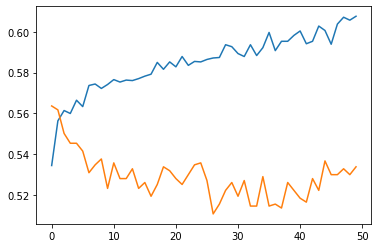

In [49]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

In [53]:
prediction  = (model.predict(X_test_norm) > 0.5).astype(int)
accuracy_score(y_test, prediction )

0.5535851966075559

# More changes to maybe have mutlinomial regression? 

In [54]:
checkpoint.describe()

,retweet_count,favorite_count,polarity,subjectivity,test,china,stock_dif,stock_up,china_similarity,xi_similarity,...,border_similarity,president_similarity,congressman_similarity,people_similarity,korea_similarity,years_similarity,farmers_similarity,going_similarity,trade_similarity,never_similarity
count,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,...,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000
mean,19813.079735,84534.203578,0.154282,0.465579,0.141149,0.036089,0.027067,0.435379,0.342459,0.526167,...,0.131029,0.219011,0.433023,0.121850,0.532239,0.265448,0.480092,0.101190,0.278569,0.102765
std,10384.792836,39760.567157,0.338861,0.275317,0.305913,0.186526,1.664811,0.495845,0.067125,0.104200,...,0.041920,0.123907,0.085100,0.065433,0.100870,0.058740,0.087544,0.031397,0.058187,0.037853
min,2.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-21.750000,0.000000,-0.232626,-0.387025,...,-0.165719,-0.344826,-0.512832,-0.399083,-0.674654,-0.309716,-0.054812,-0.584994,-0.273663,-0.408032
25%,13430.500000,59651.750000,0.000000,0.300000,0.000000,0.000000,-0.500000,0.000000,0.339754,0.536195,...,0.133036,0.147932,0.427395,0.131740,0.531322,0.264176,0.480649,0.091650,0.275898,0.089766
50%,18169.500000,78726.500000,0.087170,0.500000,0.086667,0.000000,0.000000,0.000000,0.355121,0.553768,...,0.144455,0.159800,0.449483,0.139732,0.549355,0.276733,0.497538,0.102501,0.288671,0.098628
75%,24017.500000,102456.000000,0.348122,0.651583,0.325000,0.000000,0.500000,1.000000,0.368255,0.567665,...,0.153815,0.385698,0.468053,0.147093,0.567102,0.288115,0.511316,0.114161,0.300712,0.108586
max,131283.000000,574621.000000,1.000000,1.000000,1.000000,1.000000,22.250000,1.000000,0.521302,0.861641,...,0.285948,0.550976,0.671093,0.421210,0.762448,0.435014,0.681942,0.222980,0.503452,0.273554


In [55]:
tweets_multiclass = checkpoint
down = np.where(tweets_multiclass.stock_dif < -0.25, -1, 0)
up = np.where(tweets_multiclass.stock_dif > 0.25, 1, 0)
tweets_multiclass['stock_movement'] = down + up

tweets_multiclass.describe()

,retweet_count,favorite_count,polarity,subjectivity,test,china,stock_dif,stock_up,china_similarity,xi_similarity,...,president_similarity,congressman_similarity,people_similarity,korea_similarity,years_similarity,farmers_similarity,going_similarity,trade_similarity,never_similarity,stock_movement
count,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,...,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000
mean,19813.079735,84534.203578,0.154282,0.465579,0.141149,0.036089,0.027067,0.435379,0.342459,0.526167,...,0.219011,0.433023,0.121850,0.532239,0.265448,0.480092,0.101190,0.278569,0.102765,0.019124
std,10384.792836,39760.567157,0.338861,0.275317,0.305913,0.186526,1.664811,0.495845,0.067125,0.104200,...,0.123907,0.085100,0.065433,0.100870,0.058740,0.087544,0.031397,0.058187,0.037853,0.777561
min,2.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-21.750000,0.000000,-0.232626,-0.387025,...,-0.344826,-0.512832,-0.399083,-0.674654,-0.309716,-0.054812,-0.584994,-0.273663,-0.408032,-1.000000
25%,13430.500000,59651.750000,0.000000,0.300000,0.000000,0.000000,-0.500000,0.000000,0.339754,0.536195,...,0.147932,0.427395,0.131740,0.531322,0.264176,0.480649,0.091650,0.275898,0.089766,-1.000000
50%,18169.500000,78726.500000,0.087170,0.500000,0.086667,0.000000,0.000000,0.000000,0.355121,0.553768,...,0.159800,0.449483,0.139732,0.549355,0.276733,0.497538,0.102501,0.288671,0.098628,0.000000
75%,24017.500000,102456.000000,0.348122,0.651583,0.325000,0.000000,0.500000,1.000000,0.368255,0.567665,...,0.385698,0.468053,0.147093,0.567102,0.288115,0.511316,0.114161,0.300712,0.108586,1.000000
max,131283.000000,574621.000000,1.000000,1.000000,1.000000,1.000000,22.250000,1.000000,0.521302,0.861641,...,0.550976,0.671093,0.421210,0.762448,0.435014,0.681942,0.222980,0.503452,0.273554,1.000000


In [97]:
multiclass_df = tweets_multiclass.drop(columns=['china', 'tariff', 'farmer', 'trade', 'war','text', 'stock_dif', 'stock_up', 'is_retweet', 'created_at'], errors='ignore')

In [57]:
X_train, X_test, y_train, y_test = train_test_split(multiclass_df.loc[:, multiclass_df.columns != 'stock_movement'], 
                                                         multiclass_df.stock_movement, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = multiclass_df.stock_movement)

from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(max_depth = 7, n_estimators=250, max_features='sqrt').fit(X_train, y_train)
random_forest_train_score = accuracy_score(RFclassifier.predict(X_train), y_train)
random_forest_test_score = accuracy_score(RFclassifier.predict(X_test), y_test)
print('Random Forest Accuracy on Training Set:', random_forest_train_score)
print('Random Forest Accuracy on Test Set:', random_forest_test_score)

Random Forest Accuracy on Training Set: 0.5542702911123963
Random Forest Accuracy on Test Set: 0.39707016191210487


In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [96]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
model = Sequential() 
model.add(Dense(16, input_shape = (29,)))
model.add(Dense(16, activation = 'relu')) 
model.add(Dense(3, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
hist = model.fit(X_train_norm, y_train, epochs = 50, batch_size = 16, validation_split = .2 )